<a href="https://colab.research.google.com/github/JARVIS-Materials-Design/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/alignn_ff_related_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
!git clone https://github.com/usnistgov/alignn.git

Cloning into 'alignn'...
remote: Enumerating objects: 3469, done.
remote: Counting objects: 100% (1063/1063), done.
remote: Compressing objects: 100% (352/352), done.
remote: Total 3469 (delta 793), reused 834 (delta 678), pack-reused 2406
Receiving objects: 100% (3469/3469), 32.75 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (1969/1969), done.


In [2]:
cwd=os.getcwd()
os.chdir('alignn')
!git checkout develop
!python setup.py develop
os.chdir(cwd)

Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'
/usr/local/lib/python3.10/dist-packages/setuptools/dist.py:519: InformationOnly: Normalizing '2023.04.27' to '2023.4.27'
  self.metadata.version = self._normalize_version(
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        ********************************************************************************

!!
  easy_install.initialize_options(self)
/usr/lib/python3.10/distutils/cmd.py:62: SetuptoolsDeprecationWarning: setup.py install is deprecated.

In [1]:
from jarvis.db.figshare import data
ff_db=data('alignn_ff_db')

Obtaining ALIGNN-FF training DB 300k ...
Reference:https://arxiv.org/abs/2209.05554


100%|██████████| 72.5M/72.5M [00:03<00:00, 21.4MiB/s]


Loading the zipfile...
Loading completed.


In [16]:
from alignn.ff.ff import default_path,ForceField
from alignn.graphs import Graph
import torch
import os
from jarvis.db.jsonutils import loadjson
from alignn.models.alignn_atomwise import ALIGNNAtomWise,ALIGNNAtomWiseConfig
torch.cuda.is_available = lambda : False
from jarvis.core.atoms import Atoms
from tqdm import tqdm
import numpy as np
from alignn.ff.ff import default_path,ForceField
from jarvis.core.atoms import Atoms
from alignn.ff.ff import AlignnAtomwiseCalculator,default_path
from ase.stress import full_3x3_to_voigt_6_stress
import torch


model_path = default_path()
calc = AlignnAtomwiseCalculator(path=model_path,force_mult_natoms=True)


def get_alignn_forces(atoms=[]):
    ase_atoms=atoms.ase_converter()
    ase_atoms.calc = calc
    e = ase_atoms.get_potential_energy()
    f = ase_atoms.get_forces()
    s = ase_atoms.get_stress()
    return e,f,s

torch.cuda.is_available = lambda : False
mg=[]

al_e=[]
al_f=[]
al_s=[]

t_e=[]
t_f=[]
t_s=[]
for ii,i in tqdm(enumerate(ff_db[:25])):
    #if ii<10:
        atoms = Atoms.from_dict(i['atoms'])
        #mg_f = get_m3gnet_forces(atoms)
        #mg.append(np.array(mg_f).flatten())
        e,f,s = get_alignn_forces(atoms)
        al_e.append(e)
        t_e.append(i['total_energy']*atoms.num_atoms)
        
        al_f.append(np.array(f).flatten())
        t_f.append(np.array(i['forces']).flatten())
        ts=full_3x3_to_voigt_6_stress(i['stresses'])
        al_s.append(np.array(s).flatten())
        t_s.append(np.array(ts).flatten())
        


model_path /content/alignn/alignn/ff


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/dgl-1.0.1-py3.10-linux-x86_64.egg/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
25it [00:37,  1.51s/it]


Text(0, 0.5, 'FF Forces(eV/A)')

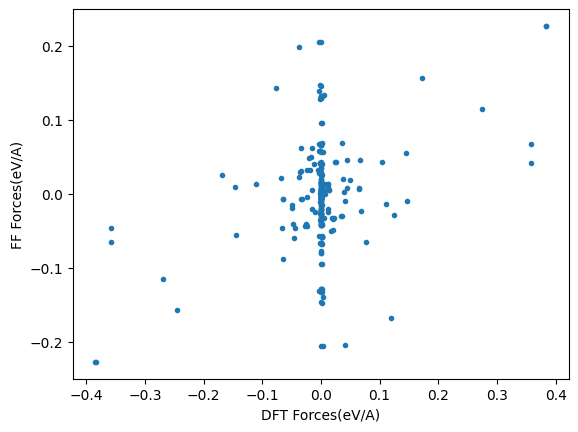

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.concatenate(t_f).flatten(),np.concatenate(al_f).flatten(),'.')
plt.xlabel('DFT Forces(eV/A)')
plt.ylabel('FF Forces(eV/A)')

Text(0, 0.5, 'FF Energy(eV)')

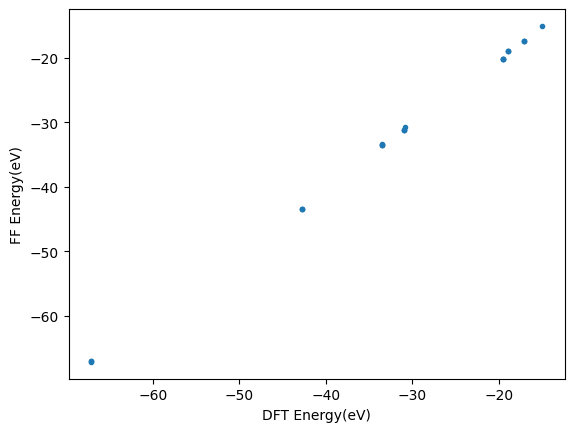

In [18]:
plt.plot(t_e,al_e,'.')
plt.xlabel('DFT Energy(eV)')
plt.ylabel('FF Energy(eV)')

Text(0, 0.5, 'FF Stress(eV/A2)')

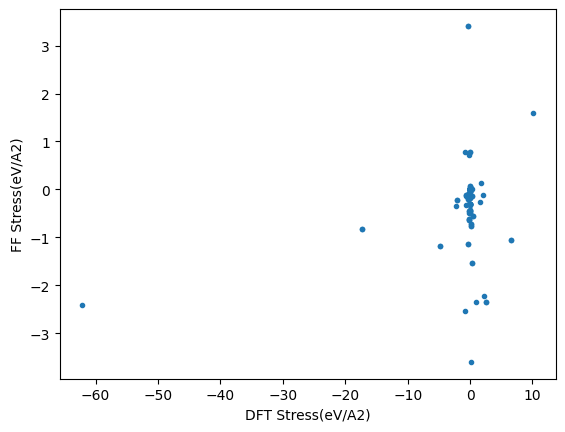

In [19]:
plt.plot(np.concatenate(t_s),-1600*np.concatenate(al_s),'.')
plt.xlabel('DFT Stress(eV/A2)')
plt.ylabel('FF Stress(eV/A2)')

In [20]:
!wget https://raw.githubusercontent.com/usnistgov/alignn/main/alignn/examples/sample_data_ff/mlearn_data/Si/id_prop.json -O id_prop.json

--2023-04-30 17:06:45--  https://raw.githubusercontent.com/usnistgov/alignn/main/alignn/examples/sample_data_ff/mlearn_data/Si/id_prop.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1292777 (1.2M) [text/plain]
Saving to: ‘id_prop.json’

id_prop.json        100%[===================>]   1.23M  --.-KB/s    in 0.007s  

2023-04-30 17:06:45 (188 MB/s) - ‘id_prop.json’ saved [1292777/1292777]



In [21]:
ff_db_Si=loadjson('id_prop.json')

In [25]:
from alignn.ff.ff import default_path,ForceField
from alignn.graphs import Graph
import torch
import os
from jarvis.db.jsonutils import loadjson
from alignn.models.alignn_atomwise import ALIGNNAtomWise,ALIGNNAtomWiseConfig
torch.cuda.is_available = lambda : False
from jarvis.core.atoms import Atoms
from tqdm import tqdm
import numpy as np
from alignn.ff.ff import default_path,ForceField
from jarvis.core.atoms import Atoms
from alignn.ff.ff import AlignnAtomwiseCalculator,default_path
from ase.stress import full_3x3_to_voigt_6_stress
import torch


model_path = default_path()
calc = AlignnAtomwiseCalculator(path=model_path,force_mult_natoms=True)


def get_alignn_forces(atoms=[]):
    ase_atoms=atoms.ase_converter()
    ase_atoms.calc = calc
    e = ase_atoms.get_potential_energy()
    f = ase_atoms.get_forces()
    s = ase_atoms.get_stress()
    return e,f,s

torch.cuda.is_available = lambda : False
mg=[]

al_e=[]
al_f=[]
al_s=[]

t_e=[]
t_f=[]
t_s=[]
for ii,i in tqdm(enumerate(ff_db_Si[:25])):
    #if ii<10:
        atoms = Atoms.from_dict(i['atoms'])
        #mg_f = get_m3gnet_forces(atoms)
        #mg.append(np.array(mg_f).flatten())
        e,f,s = get_alignn_forces(atoms)
        al_e.append(e)
        t_e.append(i['total_energy']*atoms.num_atoms)
        
        al_f.append(np.array(f).flatten())
        t_f.append(np.array(i['forces']).flatten())
        #ts=full_3x3_to_voigt_6_stress(i['stresses'])
        ts=(i['stresses'])
        al_s.append(np.array(s).flatten())
        t_s.append(np.array(ts).flatten())
        


model_path /content/alignn/alignn/ff


25it [04:53, 11.73s/it]


Text(0, 0.5, 'FF Forces(eV/A)')

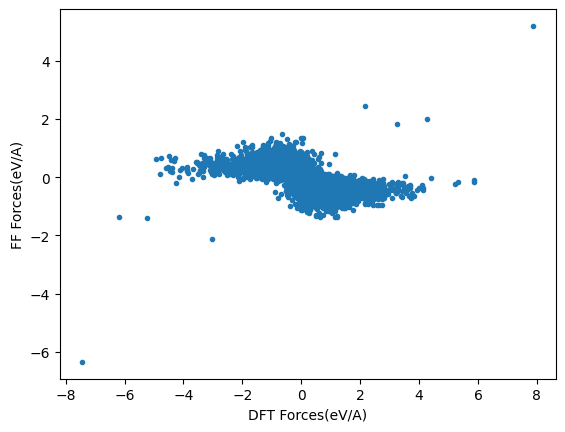

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.concatenate(t_f).flatten(),np.concatenate(al_f).flatten(),'.')
plt.xlabel('DFT Forces(eV/A)')
plt.ylabel('FF Forces(eV/A)')

Text(0, 0.5, 'FF Energy(eV)')

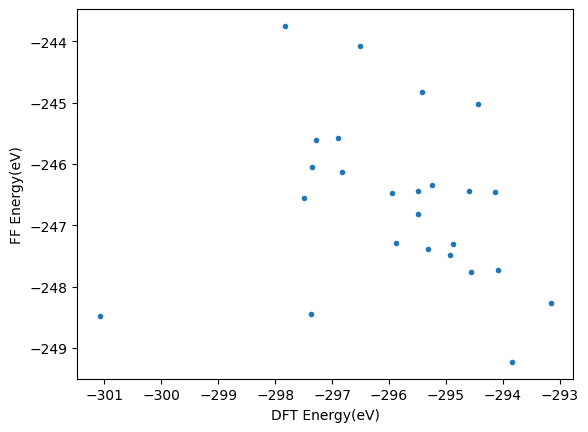

In [27]:
plt.plot(t_e,al_e,'.')
plt.xlabel('DFT Energy(eV)')
plt.ylabel('FF Energy(eV)')

Text(0, 0.5, 'FF Stress(eV/A2)')

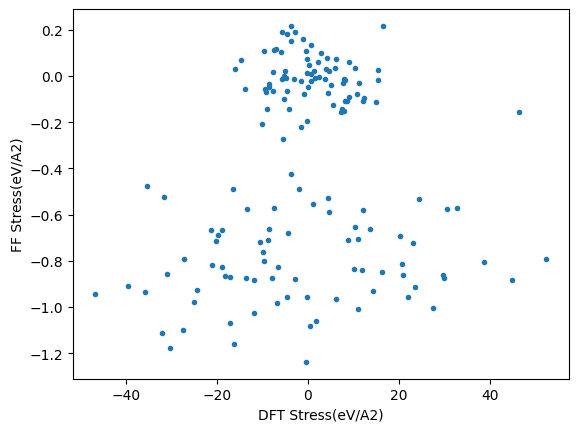

In [28]:
plt.plot(np.concatenate(t_s),-1600*np.concatenate(al_s),'.')
plt.xlabel('DFT Stress(eV/A2)')
plt.ylabel('FF Stress(eV/A2)')

In [10]:
pip install m3gnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 36.7 MB/s eta 0:00:00


In [11]:
from m3gnet.models import M3GNet, M3GNetCalculator, Potential
potential = Potential(M3GNet.load())
calculator = M3GNetCalculator(potential=potential, stress_weight=0.01)

In [12]:
from alignn.ff.ff import default_path,ForceField
from alignn.graphs import Graph
import torch
import os
from jarvis.db.jsonutils import loadjson
from alignn.models.alignn_atomwise import ALIGNNAtomWise,ALIGNNAtomWiseConfig
torch.cuda.is_available = lambda : False
from jarvis.core.atoms import Atoms
from tqdm import tqdm
import numpy as np
from alignn.ff.ff import default_path,ForceField
from jarvis.core.atoms import Atoms
from alignn.ff.ff import AlignnAtomwiseCalculator,default_path
from ase.stress import full_3x3_to_voigt_6_stress
import torch


model_path = default_path()
calc = AlignnAtomwiseCalculator(path=model_path)


def get_alignn_forces(atoms=[]):
    ase_atoms=atoms.ase_converter()
    ase_atoms.calc = calculator #calc
    e = ase_atoms.get_potential_energy()
    f = ase_atoms.get_forces()
    s = ase_atoms.get_stress()
    return e,f,s

torch.cuda.is_available = lambda : False
mg=[]

al_e=[]
al_f=[]
al_s=[]

t_e=[]
t_f=[]
t_s=[]
for ii,i in tqdm(enumerate(ff_db[:25])):
    #if ii<10:
        atoms = Atoms.from_dict(i['atoms'])
        #mg_f = get_m3gnet_forces(atoms)
        #mg.append(np.array(mg_f).flatten())
        e,f,s = get_alignn_forces(atoms)
        al_e.append(e)
        t_e.append(i['total_energy']*atoms.num_atoms)
        
        al_f.append(np.array(f).flatten())
        t_f.append(np.array(i['forces']).flatten())
        ts=full_3x3_to_voigt_6_stress(i['stresses'])
        al_s.append(np.array(s).flatten())
        t_s.append(np.array(ts).flatten())
        


model_path /content/alignn/alignn/ff


0it [00:00, ?it/s]WARNING:tensorflow:You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
1it [00:16, 16.82s/it]WARNING:tensorflow:You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
5it [00:23,  3.84s/it]WARNING:tensorflow:You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
10it [00:33,  2.49s/it]WARNING:tensorflow:You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
25it [00:40,  1.63s/it]


Text(0, 0.5, 'FF Forces(eV/A)')

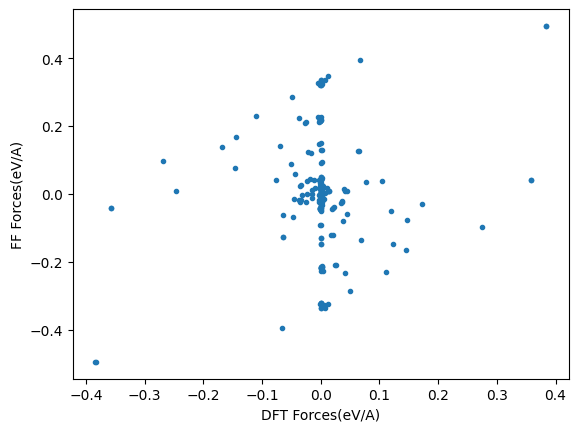

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.concatenate(t_f).flatten(),np.concatenate(al_f).flatten(),'.')
plt.xlabel('DFT Forces(eV/A)')
plt.ylabel('FF Forces(eV/A)')

Text(0, 0.5, 'FF Energy(eV)')

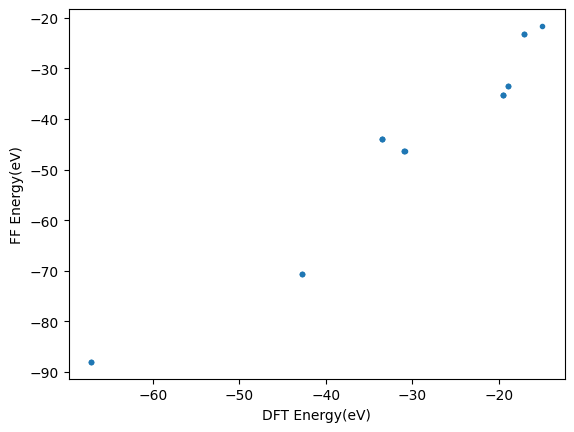

In [14]:
plt.plot(t_e,al_e,'.')
plt.xlabel('DFT Energy(eV)')
plt.ylabel('FF Energy(eV)')

Text(0, 0.5, 'FF Stress(eV/A2)')

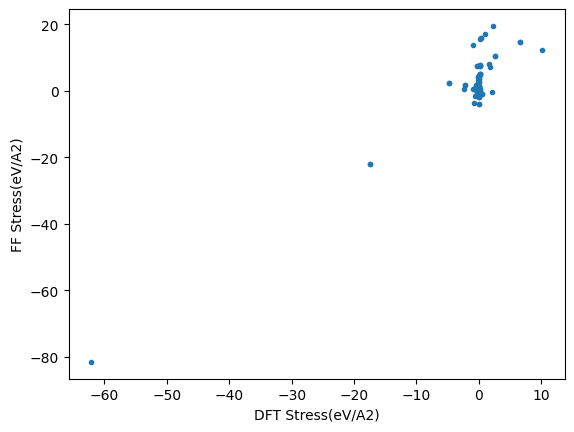

In [15]:
plt.plot(np.concatenate(t_s),-1600*np.concatenate(al_s),'.')
plt.xlabel('DFT Stress(eV/A2)')
plt.ylabel('FF Stress(eV/A2)')

In [29]:
from alignn.ff.ff import default_path,ForceField
from alignn.graphs import Graph
import torch
import os
from jarvis.db.jsonutils import loadjson
from alignn.models.alignn_atomwise import ALIGNNAtomWise,ALIGNNAtomWiseConfig
torch.cuda.is_available = lambda : False
from jarvis.core.atoms import Atoms
from tqdm import tqdm
import numpy as np
from alignn.ff.ff import default_path,ForceField
from jarvis.core.atoms import Atoms
from alignn.ff.ff import AlignnAtomwiseCalculator,default_path
from ase.stress import full_3x3_to_voigt_6_stress
import torch


model_path = default_path()
calc = AlignnAtomwiseCalculator(path=model_path,force_mult_natoms=True)


def get_alignn_forces(atoms=[]):
    ase_atoms=atoms.ase_converter()
    ase_atoms.calc = calculator
    e = ase_atoms.get_potential_energy()
    f = ase_atoms.get_forces()
    s = ase_atoms.get_stress()
    return e,f,s

torch.cuda.is_available = lambda : False
mg=[]

al_e=[]
al_f=[]
al_s=[]

t_e=[]
t_f=[]
t_s=[]
for ii,i in tqdm(enumerate(ff_db_Si[:25])):
    #if ii<10:
        atoms = Atoms.from_dict(i['atoms'])
        #mg_f = get_m3gnet_forces(atoms)
        #mg.append(np.array(mg_f).flatten())
        e,f,s = get_alignn_forces(atoms)
        al_e.append(e)
        t_e.append(i['total_energy']*atoms.num_atoms)
        
        al_f.append(np.array(f).flatten())
        t_f.append(np.array(i['forces']).flatten())
        #ts=full_3x3_to_voigt_6_stress(i['stresses'])
        ts=(i['stresses'])
        al_s.append(np.array(s).flatten())
        t_s.append(np.array(ts).flatten())
        


model_path /content/alignn/alignn/ff


25it [00:05,  4.99it/s]


Text(0, 0.5, 'FF Forces(eV/A)')

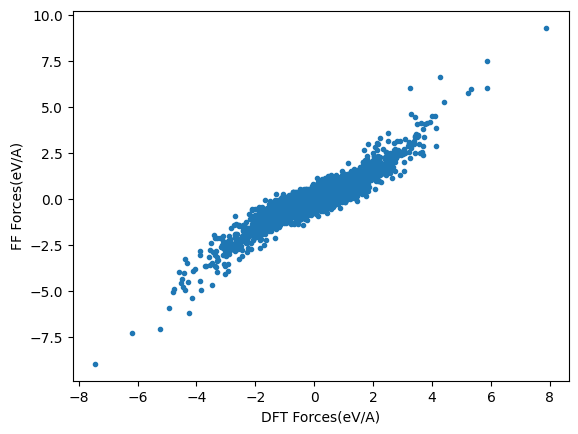

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.concatenate(t_f).flatten(),np.concatenate(al_f).flatten(),'.')
plt.xlabel('DFT Forces(eV/A)')
plt.ylabel('FF Forces(eV/A)')

Text(0, 0.5, 'FF Energy(eV)')

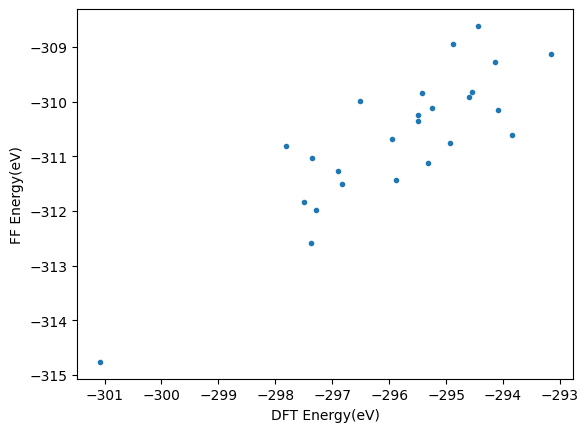

In [31]:
plt.plot(t_e,al_e,'.')
plt.xlabel('DFT Energy(eV)')
plt.ylabel('FF Energy(eV)')

Text(0, 0.5, 'FF Stress(eV/A2)')

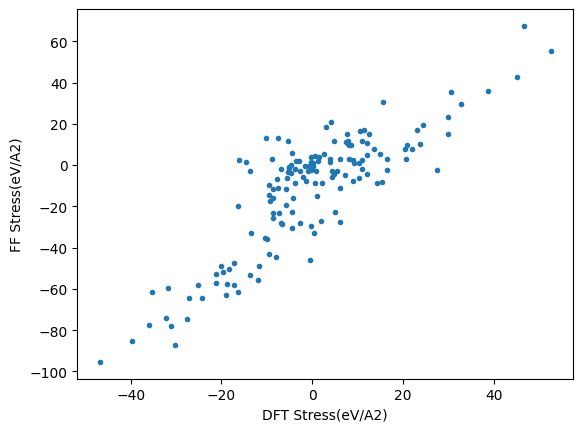

In [32]:
plt.plot(np.concatenate(t_s),-1600*np.concatenate(al_s),'.')
plt.xlabel('DFT Stress(eV/A2)')
plt.ylabel('FF Stress(eV/A2)')